In [1]:
import pandas as pd
from modules import preprocessing as pre
from modules import extract_keywords as ek
from modules import visualise as vis
import models.ovr_model as ovr
import hyperparm as hpt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import random
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
import gensim.downloader
from tqdm import tqdm

MIN_COSINE_VALUE = 0.28

def load_word2vec_model():
    with tqdm(total=1, desc="Loading Word2Vec Model", unit="model") as pbar:
        w2v_model = gensim.downloader.load('word2vec-google-news-300')
        pbar.update(1)
    return w2v_model

w2v = load_word2vec_model()

def merge_lists(l1, min_cosine_value, w2v, ref_list):
    final_list = []
    
    for word in l1:
        if word in w2v:
            similarities = []
            for ref_word in ref_list:
                if ref_word in w2v:
                    sim = w2v.similarity(word, ref_word)
                    similarities.append(sim)
            if any(sim >= min_cosine_value for sim in similarities):
                final_list.append(word)
    if 'use' in final_list: final_list.remove('use')
    elif 'also' in final_list: final_list.remove('also')
    return final_list

def better_keywords(df):
    for i in range(len(df)):
        if df.iloc[i]['STRIDE'] == 0:
            updated_list = merge_lists(df.loc[i, 'NameDesc'], MIN_COSINE_VALUE, w2v, S_final)
        elif df.iloc[i]['STRIDE'] == 1:
            updated_list = merge_lists(df.loc[i, 'NameDesc'], MIN_COSINE_VALUE, w2v, E_final)
        elif df.iloc[i]['STRIDE'] == 2:
            updated_list = merge_lists(df.loc[i, 'NameDesc'], MIN_COSINE_VALUE, w2v, D_final)
        elif df.iloc[i]['STRIDE'] == 3:
            updated_list = merge_lists(df.loc[i, 'NameDesc'], MIN_COSINE_VALUE, w2v, I_final)
        elif df.iloc[i]['STRIDE'] == 4:
            updated_list = merge_lists(df.loc[i, 'NameDesc'], MIN_COSINE_VALUE, w2v, R_final)
        else:
            updated_list = merge_lists(df.loc[i, 'NameDesc'], MIN_COSINE_VALUE, w2v, T_final)
        
        df.at[i, 'NameDesc'] = updated_list
    return df

def basic_processing(df):
    words_to_remove = ["e.g.", "code", "may", "attack", "system", "adversary", "Adversaries"]
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: x.replace(word, ''))
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: re.sub(r'\b' + re.escape(word) + r'\b', '', x))

    # df['NameDesc'] = df['NameDesc'].str.replace(r"\b(" + "|".join(words_to_remove) + r")\b", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("<br><br>", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("\(Citation:.*?\)", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("http\S+", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("  +", " ", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("[^A-Za-z]", " ", regex=True)
    return df

def rm_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['NameDesc'] = df['NameDesc'].apply(lambda x: [word for word in x if word not in stop_words])
    # print(f"Removed stopwords:\n {df.head(3).NameDesc}\n")
    return df

def lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    def lemmatize_tokens(tokens):
        def get_wordnet_pos(word):
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
        return lemmas
    df['NameDesc'] = df['NameDesc'].apply(lambda x: lemmatize_tokens(x))
    # print(f"Lemmatized words:\n {df.head(3).NameDesc}")
    return df

def text_preprocessing(df):
    basic_processing(df)
    df['NameDesc'] = df['NameDesc'].apply(lambda x: word_tokenize(x))
    rm_stopwords(df)
    lemmatize(df)

    k = random.randint(0, len(df)) # arbitary row to show that words have been removed
    print(f"Bef rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    df['NameDesc'] = df['NameDesc'].apply(lambda x: list(set([word.lower() for word in x]))) # to remove duplicates
    print(f"Aft rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    print(f"Removed duplicates:\n {df.head(3).NameDesc}")

    print("=========================================")
    return df

def change_label(df):
    stride_mapping = { # STRIDE
        1: 1, # E
        10: 2, # D
        100: 3, # I
        1000: 4, # R
        10000: 5, # T
        100000: 0, # S
        11000: 4,
        100100: 0
    }
    df['STRIDE'] = df['STRIDE'].map(stride_mapping)

def split_data(df, train_set_size, test_set_size):
    '''
    train_set_size + test_set_size + dev_set_size = 1
    '''
    while True:
        df_train, temp = train_test_split(df, test_size=1-train_set_size)
        df_test, df_dev = train_test_split(temp, test_size=test_set_size)

        change_label(df_train)
        change_label(df_test)
        change_label(df_dev)

        c = set([0, 1, 2, 3, 4, 5])
        if set(df_train['STRIDE'].unique()) != c or \
            set(df_test['STRIDE'].unique()) != c or \
            set(df_dev['STRIDE'].unique()) != c:
                continue
        else: break
    return df_train, df_test, df_dev

# keywords defined from each STRIDE category
S = ['authenticate', 'username', 'password', 'access'] #add more words
T = ['modify', 'persistent', 'database', 'alter', 'open', 'network', 'internet'] #add more words
R = ['deny', 'action', 'prove', 'non-repudiation', 'item', 'sign', 'receipt', 'receive', 'evidence', 'package', 'untrace',]
I = ['exposure', 'individual', 'access', 'file', 'granted', 'intruder', 'transit']
D = ['denial', 'service', 'dos', 'web', 'server', 'unavailable', 'unusable', 'system', 'available', 'reliable']
E = ['unprivileged', 'privileged', 'access', 'compromise', 'entire', 'system', 'elevation', 'penetrate', 'defenses', 'untrusted', 'trusted']

# words to keep (manual filtering from keywords extracted from text_preprocessing())
S_keep = ['information', 'detection', 'take',  'include', 'malicious', 'control', 'network', 'search', 'name', 'access', 'infrastructure', 'traffic', 'data', 'suspicious', 'trust', 'reconnaissance', 'email', 'phishing', 'resource', 'initial', 'visibility', 'monitor', 'server', 'form', 'open', 'potentially', 'websites', 'address', 'process', 'detect', 'credential', 'file', 'certificate', 'internet', 'install', 'key', 'online', 'link', 'source']
E_keep = ['process', 'access', 'file', 'execute', 'activity', 'execution', 'network', 'behavior', 'create', 'control', 'log', 'privilege', 'application', 'service', 'within', 'event', 'account', 'modify', 'run', 'abuse', 'monitoring', 'environment', 'binary', 'credential', 'enable', 'api', 'exe', 'function', 'payload', 'target', 'method', 'services', 'launch', 'root', 'os', 'many''accounts']
D_keep = ['service', 'target', 'tool', 'command', 'cause', 'server', 'network', 'outside', 'denial', 'dos', 'availability', 'high', 'destruction', 'infrastructure']
I_keep = ['data', 'network', 'activity', 'access', 'behavior', 'environment', 'process', 'detection', 'remote', 'base', 'target', 'tool', 'file', 'api', 'traffic', 'acquire', 'application', 'host', 'infrastructure', 'device']
R_keep = ['user', 'application', 'api', 'activity', 'audit', 'source', 'system', 'native', 'hide', 'error', 'intrusion', 'function', 'record', 'clear', 'gcp', 'permission', 'analysis', 'collection', 'updatesink', 'indicate', 'detection', 'data', 'collect', 'environment', 'call', 'limit', 'cloudtrail', 'loss', 'conduct', 'prior', 'delete', 'cloud', 'configservicev', 'cloudwatch', 'diagnostic', 'capability', 'sufficient', 'insight', 'avoid']
T_keep = ['malicious', 'file', 'activity', 'process', 'execute', 'access', 'information', 'control', 'software', 'modify', 'network', 'data', 'abuse', 'exe', 'manipulate', 'bypass', 'malware', 'functionality', 'integrity', 'dll', 'anomaly', 'install']

# combine both lists together by group
S_final = S + S_keep
T_final = T + T_keep
R_final = R + R_keep
I_final = I + I_keep
D_final = D + D_keep
E_final = E + E_keep

/var/folders/y3/qz4wgjts6dj2m3kdg2nq67200000gn/T/ipykernel_6777/1592899246.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chufeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chufeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/chufeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chufe

In [3]:
tfidf_vectorizer = TfidfVectorizer()
base_classifier = LogisticRegression()

clf = OneVsRestClassifier(base_classifier)

def vectorize(df_train, df_test):
    df_train['NameDesc'] = df_train['NameDesc'].apply(lambda x: ' '.join(x))
    df_test['NameDesc'] = df_test['NameDesc'].apply(lambda x: ' '.join(x))
    # df_dev['NameDesc'] = df_dev['NameDesc'].apply(lambda x: ' '.join(x))

    X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['NameDesc']).toarray()
    X_test_tfidf = tfidf_vectorizer.transform(df_test['NameDesc']).toarray()
    # X_val_tfidf = tfidf_vectorizer.transform(df_dev['NameDesc']).toarray()

    y_train = df_train['STRIDE'].values
    y_test = df_test['STRIDE'].values
    # y_val = df_dev['STRIDE'].values

    return X_train_tfidf, X_test_tfidf, y_train, y_test

def train_loop(X_train_tfidf, X_test_tdift, y_train, y_test):
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_train_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return y_pred, acc

In [4]:
from sklearn.model_selection import train_test_split

def split_data2(df, train_set_size):
    '''
    train_set_size + test_set_size + dev_set_size = 1
    '''
    while True:
        df_train, df_test = train_test_split(df, test_size=1 - train_set_size)
        
        # Ensure both df_train and df_test have the same number of samples
        min_samples = min(len(df_train), len(df_test))
        df_train = df_train.sample(n=min_samples)
        df_test = df_test.sample(n=min_samples)

        change_label(df_train)
        change_label(df_test)

        c = set([0, 1, 2, 3, 4, 5])
        if set(df_train['STRIDE'].unique()) != c or set(df_test['STRIDE'].unique()) != c:
            continue
        else:
            break

    return df_train, df_test

In [5]:
PATH = '../data/external/mitre-classified.xlsx'
df = pd.read_excel(PATH)

# train test dev split
df_train, df_test = split_data2(df, train_set_size=0.3)

col_toDrop = ['Ref', 'Name', 'Desc', 'Confidentiality', 'Integrity', 'Availability', 'Ease Of Exploitation', 'References', 'Unnamed: 0']
df_train = df_train.reset_index(drop=True).drop(columns=col_toDrop)
df_test = df_test.reset_index(drop=True).drop(columns=col_toDrop)
# df_dev = df_dev.reset_index(drop=True).drop(columns=col_toDrop)
print("Data split:")
print(f"df_train:\n{df_train['STRIDE'].value_counts()}\n")
# print(f"df_dev:\n{df_dev['STRIDE'].value_counts()}\n")
print(f"df_test:\n{df_test['STRIDE'].value_counts()}")
print("=========================================\n")


# trivially extract keywords
df_train = text_preprocessing(df_train)
df_test = text_preprocessing(df_test)
# df_dev = text_preprocessing(df_dev)
print("Trivial text preprocessing:")
print(f"df_train:\n{df_train.head(1)}\n")

# obtain better set of keywords
df_train = better_keywords(df_train)

X_train_tfidf, X_test_tfidf, y_train, y_test = vectorize(df_train, df_test)

Data split:
df_train:
STRIDE
1    62
3    49
5    18
0    13
2     2
4     1
Name: count, dtype: int64

df_test:
STRIDE
1    70
3    43
5    20
0     8
2     3
4     1
Name: count, dtype: int64

Bef rm duplicates: 281
Aft rm duplicates: 135
Removed duplicates:
 0    [case, internet, environment, ensure, maliciou...
1    [environment, powershell, additional, use, pas...
2    [grouppolicycontainer, environment, powershell...
Name: NameDesc, dtype: object
Bef rm duplicates: 142
Aft rm duplicates: 95
Removed duplicates:
 0    [environment, powershell, management, staged, ...
1    [powershell, environment, management, learns, ...
2    [amis, environment, match, malicious, amazon, ...
Name: NameDesc, dtype: object
Trivial text preprocessing:
df_train:
                                            NameDesc  STRIDE
0  [case, internet, environment, ensure, maliciou...       5



In [6]:
print("Shapes after vectorization:")
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)
# print("X_val_tfidf shape:", X_val_tfidf.shape)    
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
# print("y_val shape:", y_val.shape)

Shapes after vectorization:
X_train_tfidf shape: (145, 1327)
X_test_tfidf shape: (145, 1327)
y_train shape: (145,)
y_test shape: (145,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nConfusion Matrix:")
print(conf_matrix)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_tfidf, y_train)

y_pred_rf = clf_rf.predict(X_test_tfidf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_rf)
print("\nConfusion Matrix:")
print(conf_matrix_rf)

In [ ]:
y_pred, acc = train_loop(X_train_tfidf, X_test_tfidf, y_train, y_test)

In [7]:
from tensorflow.keras.layers import Layer, Permute, Reshape, Multiply, Lambda, Softmax, Dot
import tensorflow.keras.backend as K

class SelfAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(SelfAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        super(SelfAttentionLayer, self).build(input_shape)

    def call(self, x):
        # eij = tanh(Wx + b)
        eij = K.tanh(K.dot(x, self.W) + self.b)
        
        # ai = exp(eij) / sum_j(exp(eij))
        ai = K.exp(eij)
        weights = ai / K.sum(ai, axis=2, keepdims=True)  # sum over the features dimension
        
        # weighted input
        weighted_input = x * weights
        return weighted_input

    def compute_output_shape(self, input_shape):
        return input_shape

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1327)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1327, 128)            169856    ['input_2[0][0]']             
                                                                                                  
 activation_2 (Activation)   (None, 1327, 128)            0         ['embedding_1[0][0]']         
                                                                                                  
 self_attention_layer_1 (Se  (None, 1327, 128)            16512     ['activation_2[0][0]']        
 lfAttentionLayer)                                                                          

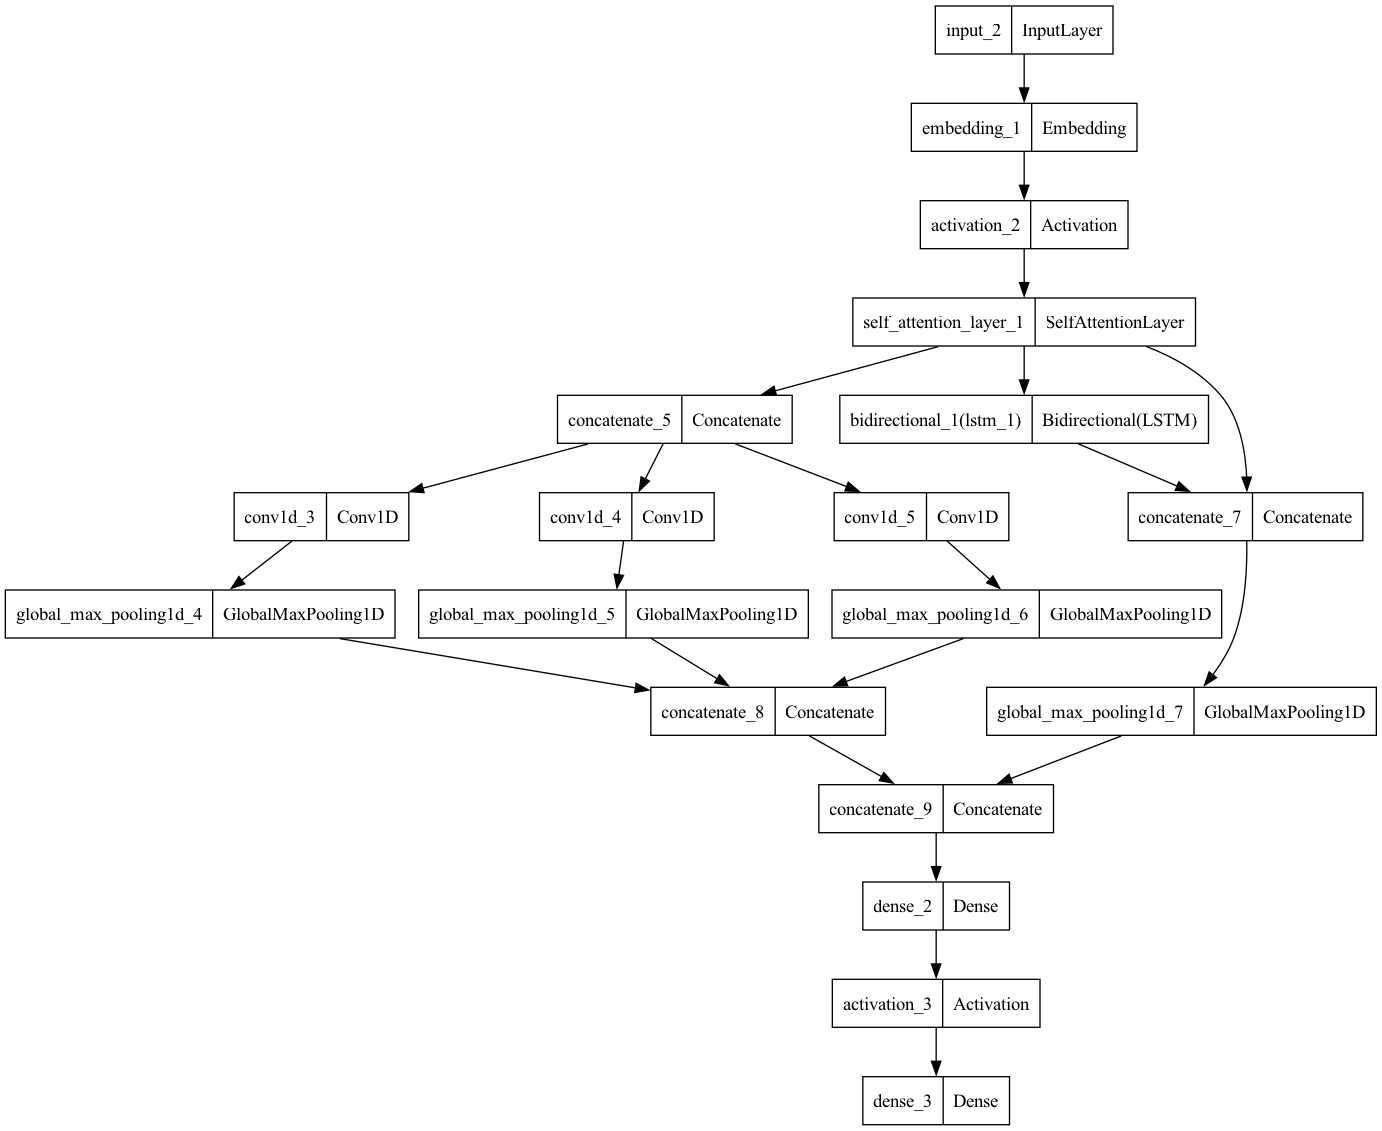

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Activation
from tensorflow.keras.models import Model

vocab_size = X_train_tfidf.shape[1]
embedding_dim = 128
sequence_length = 500  # length of your input sequences
num_classes = 6
num_filters = 256
kernel_size = 3
pool_size = 2

# Input Layer
inputs = Input(shape=(vocab_size,))

# Word Embedding Layer
x = Embedding(vocab_size, embedding_dim)(inputs)

# tanh activation layer
x = Activation('tanh')(x)

# Self-attention layer
attention_output = SelfAttentionLayer()(x)
x = Concatenate()([attention_output])

# Convolutional Layers with different kernel sizes
conv_blocks = []
for i in range(3):
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation="relu", strides=1)(x)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

# concatenate results
x = Concatenate()(conv_blocks)

# BLSTM Layer
blstm = Bidirectional(LSTM(128, return_sequences=True))(attention_output)
x = Concatenate()([attention_output, blstm])
blstm = GlobalMaxPooling1D()(x)

# concatenate convolutional features and BLSTM features
x = Concatenate()([x for x in conv_blocks])
x = Concatenate()([x, blstm])

# Fully Connected Layer
x = Dense(128)(x)
x = Activation('tanh')(x)

# Output Layer
predictions = Dense(num_classes, activation='softmax')(x)

# Build and compile the model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=False, show_layer_names=True)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def train_loop(model, X_train_tfidf, y_train, X_val_tfidf, y_val, NUM_EPOCHS, BATCH_SIZE):
    hist = model.fit(
        X_train_tfidf, y_train,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(X_val_tfidf, y_val),
        verbose=1,
        callbacks=[early_stop,]
    )
    return hist, model

In [13]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
y_pred, acc = train_loop(model, X_train_tfidf, y_train_encoded, X_test_tfidf, y_test_encoded, 100, 32)

Epoch 1/100
5/5 [==============================] - 12s 2s/step - loss: 1.7643 - accuracy: 0.4276 - val_loss: 1.6763 - val_accuracy: 0.4828
Epoch 2/100
5/5 [==============================] - 8s 2s/step - loss: 1.6038 - accuracy: 0.4276 - val_loss: 1.3311 - val_accuracy: 0.4828
Epoch 3/100
5/5 [==============================] - 10s 2s/step - loss: 1.3450 - accuracy: 0.4276 - val_loss: 1.2765 - val_accuracy: 0.4828
Epoch 4/100
5/5 [==============================] - 12s 2s/step - loss: 1.3216 - accuracy: 0.4276 - val_loss: 1.2908 - val_accuracy: 0.4828
Epoch 5/100
5/5 [==============================] - 10s 2s/step - loss: 1.3235 - accuracy: 0.4276 - val_loss: 1.2791 - val_accuracy: 0.4828
Epoch 6/100
5/5 [==============================] - 10s 2s/step - loss: 1.3127 - accuracy: 0.4276 - val_loss: 1.2702 - val_accuracy: 0.4828
Epoch 7/100
5/5 [==============================] - 10s 2s/step - loss: 1.3064 - accuracy: 0.4276 - val_loss: 1.2734 - val_accuracy: 0.4828
Epoch 8/100
5/5 [===========

In [14]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_data(hist, model, X_val_padded, y_val, classes):
    # output_dir = 'data/results'

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    y_pred = np.argmax(model.predict(X_val_padded), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes, square=True)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    # plt.savefig(f"{output_dir}/confusionmatrix.png", bbox_inches='tight')
    plt.show()
    plt.pause(2)
    return

def plot_cm(cm, model=0, X_val_padded=0, y_val=0, classes=0):
    # output_dir = 'data/results'
    if (model or X_val_padded or y_val or classes):
        y_pred = np.argmax(model.predict(X_val_padded), axis=1)
        cm = confusion_matrix(y_val, y_pred)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes, square=True)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    # plt.savefig(f"{output_dir}/confusionmatrix.png", bbox_inches='tight')
    plt.show()
    plt.pause(2)
    return

In [15]:
plot_data(hist=y_pred, model=acc, X_val_padded=X_test_tfidf, y_val=y_test, classes=[0,1,2,3,4,5])

5/5 [==============================] - 3s 478ms/step


Replicate

In [ ]:
import os
!export REPLICATE_API_TOKEN=r8_cQ7dTejgV4S3VMwyYu5wiv7VUSlAT8I0ptqOH
os.environ['REPLICATE_API_TOKEN'] = 'r8_cQ7dTejgV4S3VMwyYu5wiv7VUSlAT8I0ptqOH'
import replicate

In [ ]:
prompt = "The STRIDE security framework is defined by Spoofing, Tampering, Repudiation, Information disclosure, Denial of service, Elevation of privilege. Using this, which category do you think the following attack should be classfied under? The attacker is able to access the system and modify the data."

In [ ]:
# The meta/llama-2-13b-chat model can stream output as it's running.
api = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])
output = api.run(
    # "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
    "meta/llama-2-13b-chat",
        input={"prompt": prompt,}
    )
for item in output:
    print(item, end="")